# Kaggle Competition House Prices
By: Rohinesh Ram

# 0. Imports / Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Scoring used will be negative root mean squared because scikit-learn only implerments maximization

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statistics

def get_regressor_neg_rms(model, X, y, cv):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    # Cross validation
    scores = cross_validate(model, X, y, cv=cv, scoring= 'neg_root_mean_squared_error', return_train_score=True)
    
    # get average scores
    train_mean_rms = statistics.mean(scores['train_score'])
    test_mean_rms = statistics.mean(scores['test_score'])
    
    return train_mean_rms, test_mean_rms

In [3]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

# 1. Load the Data

- two data sets from Kaggle, testset and trainset
- also txt of feature descriptions

In [4]:
# Train data set
df_train = pd.read_csv('data_folder/train.csv').set_index('Id')
# Test data set
df_test = pd.read_csv('data_folder/test.csv').set_index('Id')
# Data description
f = open("data_folder/data_description.txt", "r")

# Display each
print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Train Data

In [5]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Test Data

In [6]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 2. Missing Data

## 2.1 Train Set

In [7]:
nan_cols = df_train.columns[df_train.isna().any()]
print("Columns with missing data:", nan_cols)

Columns with missing data: Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


Some of the columns with categorical data are labelled 'NA' which pandas interprets as NaN, these data could be missing OR should be 'NA'. It can be assumed that NaN values for categorical features are supposed to be 'NA'.

In [8]:
missing_na = [
    'Alley',
    'MasVnrType' ,
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature']

In [9]:
# Fill NA back
for label in missing_na:
    df_train[label] = df_train[label].fillna('NA');
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


## 2.2 Test Set

In [10]:
df_test.columns[df_test.isna().any()]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

These features should be 'NA'.

In [11]:
missing_data = [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature']

In [12]:
# only keep rows with non missing data
for label in missing_data:
    df_test[label] = df_test[label].fillna('NA')
df_test.columns[df_test.isna().any()]

Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SaleType'],
      dtype='object')

Still have missing categorical and ordinal data. Fill with most frequent.

In [13]:
more_missing_data = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                    'KitchenQual', 'Functional', 'SaleType']

In [14]:
for label in more_missing_data:
    mode = df_test[label].mode()[0]
    df_test[label] = df_test[label].fillna('mode')
df_test.columns[df_test.isna().any()]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

# 3. Prepare Feature matrix and Target Vector

In [15]:
y_train = df_train['SalePrice']
X_train = df_train.loc[:,'MSSubClass':'SaleCondition']
X_test = df_test.loc[:,'MSSubClass':'SaleCondition']

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)

X train shape: (1460, 79)
y train shape: (1460,)
X test shape: (1459, 79)


# 4. Pre-process

We have a mix of numerical, categorical features, and ordinal features, lets find which are which:

**Numerical**: LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

Some of the numerical features are actually categorical and ordinal features

**Categorical**: MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition, MoSold, YrSold 

Features related to quality or condition were considered ordinal because they imply some sort of rank or order, i.e. good quality is better than fair quality.

**Ordinal**: OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence

In [16]:
numerical = 'LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal'
categorical = 'MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition, MoSold, YrSold'
ordinal = 'OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence'

numerical = numerical.split(', ')
categorical = categorical.split(', ')
ordinal = ordinal.split(', ')

print("Number of numerical features:", len(numerical))
print("Number of categorical features:", len(categorical))
print("Number of ordinal features:", len(ordinal))


Number of numerical features: 31
Number of categorical features: 32
Number of ordinal features: 16


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# this is the pre-processor
ct = ColumnTransformer(
    [
    ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore' ), categorical),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal),
    ('numerical', SimpleImputer(missing_values= np.nan, strategy='mean'), numerical)])
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print("Train Shape after pre-process", X_train_trans.shape)

Train Shape after pre-process (1460, 273)


# 5. Inspect Data

## 5.1 Distribution of the sales price

Text(0.5, 1.0, 'Distribution of Sales Price')

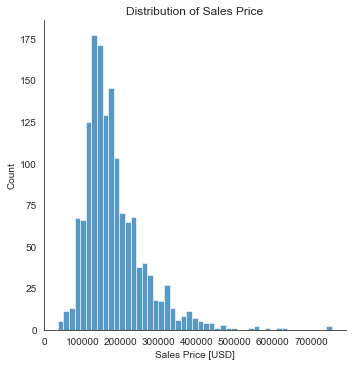

In [18]:
sns.set_style("white")
ax = sns.displot(y_train)
ax.set_xlabels("Sales Price [USD]")
plt.title("Distribution of Sales Price")

In [19]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- Majority of houses sold within the 100K - 300K range
- outliers in the +700K Range

## 5.2 Correlation between features

Correlation between numerical features only

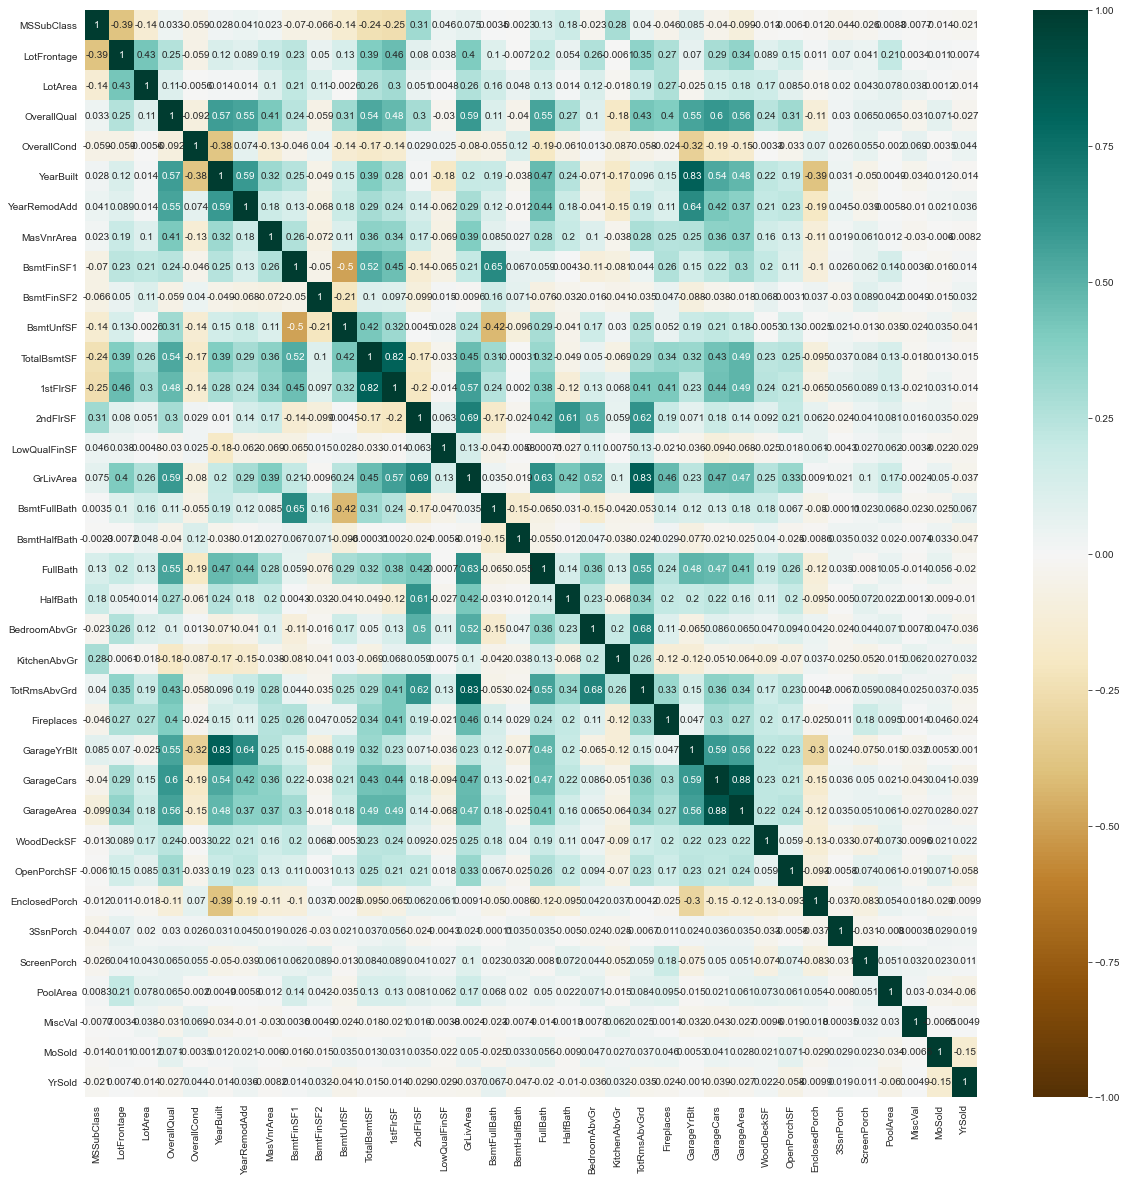

In [20]:
X_corr = X_train.corr()
f = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(X_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

## 5.3 Range of Features

Note: These are all numerical features, but some of these features are actually categorical, e.g. MSSubclass

In [21]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


# 6. Model Comparison using CV

Using RandomForestRegressor and GradientBoostingRegressor and 5-fold cross validation to calculate training and validation nRMS in units of USD

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

# instantiate the models with default params
models = [RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

for model in models:
    model_name = type(model).__name__
    test_score, val_score = get_regressor_neg_rms(model, X_train_trans, y_train, 5)
    print(model_name + "\n  Training nRMS[USD]: {0:.2f}\n  Validation nRMS[USD]: {1:.2f}".format(test_score, val_score))

RandomForestRegressor
  Training nRMS[USD]: -11296.37
  Validation nRMS[USD]: -30424.43
GradientBoostingRegressor
  Training nRMS[USD]: -13893.98
  Validation nRMS[USD]: -26338.94


RFR has a better training nRMS than that GBR but it has a worse validation score. Both models appear to be overfitting. I will tune the hyper paramters of GBR.

# 7. Tune GradientBoostedRegressor

Approach: Grid search with CV

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
                'n_estimators': [100, 300, 500],
                'learning_rate': [0.01, 0.1, 1.0]
            }

grid_grad = GridSearchCV(GradientBoostingRegressor(random_state=79),
                    param_grid,
                    cv=3,
                    scoring='neg_root_mean_squared_error')

In [27]:
grid_grad.fit(X_train_trans, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=79),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error')

In [28]:
print("Best parametars for GBR:",grid_grad.best_params_)
print("Best nRMS: {0:.2f}".format(grid_grad.best_score_))

Best parametars for GBR: {'learning_rate': 0.1, 'n_estimators': 500}
Best nRMS: -25433.31


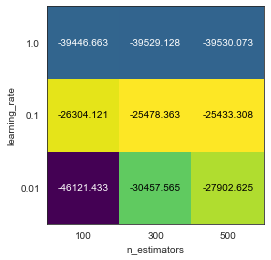

In [29]:
plot_grid_search_results(grid_grad)

# 8. Retrain GBR with Best Params

Retraining GradientBoostingRegressor from grid search results

In [30]:
print("Best params:", grid_grad.best_estimator_)

Best params: GradientBoostingRegressor(n_estimators=500, random_state=79)


In [31]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=79)
model.fit(X_train_trans, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=79)

# 9. Evaluate on Test Data

## 9.1 Preprocessing

In [32]:
X_test_trans = ct.transform(X_test)

## 9.2 Evaluation

In [33]:
y_test_pred = model.predict(X_test_trans)
y_train_pred= model.predict(X_train_trans)

Output and submit to kaggle

In [34]:
output = pd.DataFrame({'id':X_test.index, 'SalePrice':y_test_pred})
output.to_csv('submissions.csv', index=False)

Kaggle Score was 0.13164 scored 1519 on leaderboard